# ETrade CSV Parser Demo

This notebook demonstrates how to use the portfolio_analysis library to parse ETrade CSV files and extract useful position data.

The library uses Pydantic for data validation and pandas for efficient CSV parsing.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from portfolio_analysis import parse_etrade_csv


In [2]:
# Set seaborn style for better looking plots
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.style.use('seaborn-v0_8')

In [3]:
# Path to the ETrade CSV file
csv_path = "../in/PortfolioDownload.csv"

print(f"Parsing: {csv_path}")

Parsing: ../in/PortfolioDownload.csv


The `parse_etrade_csv()` function provides a quick way to get all the data at once.

In [4]:
# Parse the CSV using the convenience function
positions_df, lots_df, cash_position, portfolio_summary = parse_etrade_csv(csv_path)

print(f"Cash Position: ${cash_position:,.2f}")
print(f"\nPortfolio Summary:")
for key, value in portfolio_summary.items():
    if isinstance(value, float):
        if 'dollar' in key or 'value' in key:
            print(f"  {key}: ${value:,.2f}")
        else:
            print(f"  {key}: {value:.2f}")
    else:
        print(f"  {key}: {value}")

Cash Position: $0.61

Portfolio Summary:
  total_value: $230,094.35
  total_position_value: $230,093.74
  cash_position: 0.61
  number_of_positions: 17
  total_gain_dollar: $78,675.42
  average_gain_percent: 62.18


## Positions Analysis

Let's examine the positions, starting with the largest holdings by value.

In [5]:
if positions_df is not None and not positions_df.empty:
    print("=== Top 10 Positions by Value ===")
    top_positions = positions_df.nlargest(10, 'value')
    display(top_positions[['symbol', 'quantity', 'last_price', 'value', 'total_gain_percent']].round(2))
else:
    print("No positions found")

=== Top 10 Positions by Value ===


,symbol,quantity,last_price,value,total_gain_percent
13,QQQM,158.68,209.66,33269.48,8.14
10,MSFT,72.83,450.18,32786.16,113.62
16,VTI,109.41,285.04,31187.08,15.86
3,AMZN,150.00,200.99,30148.50,66.10
12,QQQ,56.40,509.24,28719.10,57.91
7,GOOGL,138.65,168.47,23358.03,124.54
0,AAPL,48.58,195.27,9485.83,22.05
15,V,19.74,353.54,6980.65,104.35
11,NVDA,51.03,131.29,6699.47,157.44
5,COST,6.21,1008.50,6266.82,89.11


In [6]:
if positions_df is not None and not positions_df.empty:
    print("=== Top 5 Gainers by Percentage ===")
    top_gainers = positions_df.nlargest(5, 'total_gain_percent')
    for _, row in top_gainers.iterrows():
        print(f"{row['symbol']}: {row['total_gain_percent']:.2f}% (${row['total_gain_dollar']:,.2f})")
else:
    print("No positions found")

=== Top 5 Gainers by Percentage ===
NVDA: 157.44% ($4,097.18)
GOOGL: 124.54% ($12,955.32)
MSFT: 113.62% ($17,438.38)
MA: 106.90% ($2,403.45)
V: 104.35% ($3,564.57)


## Portfolio Visualization

Let's create some simple visualizations of the portfolio data.

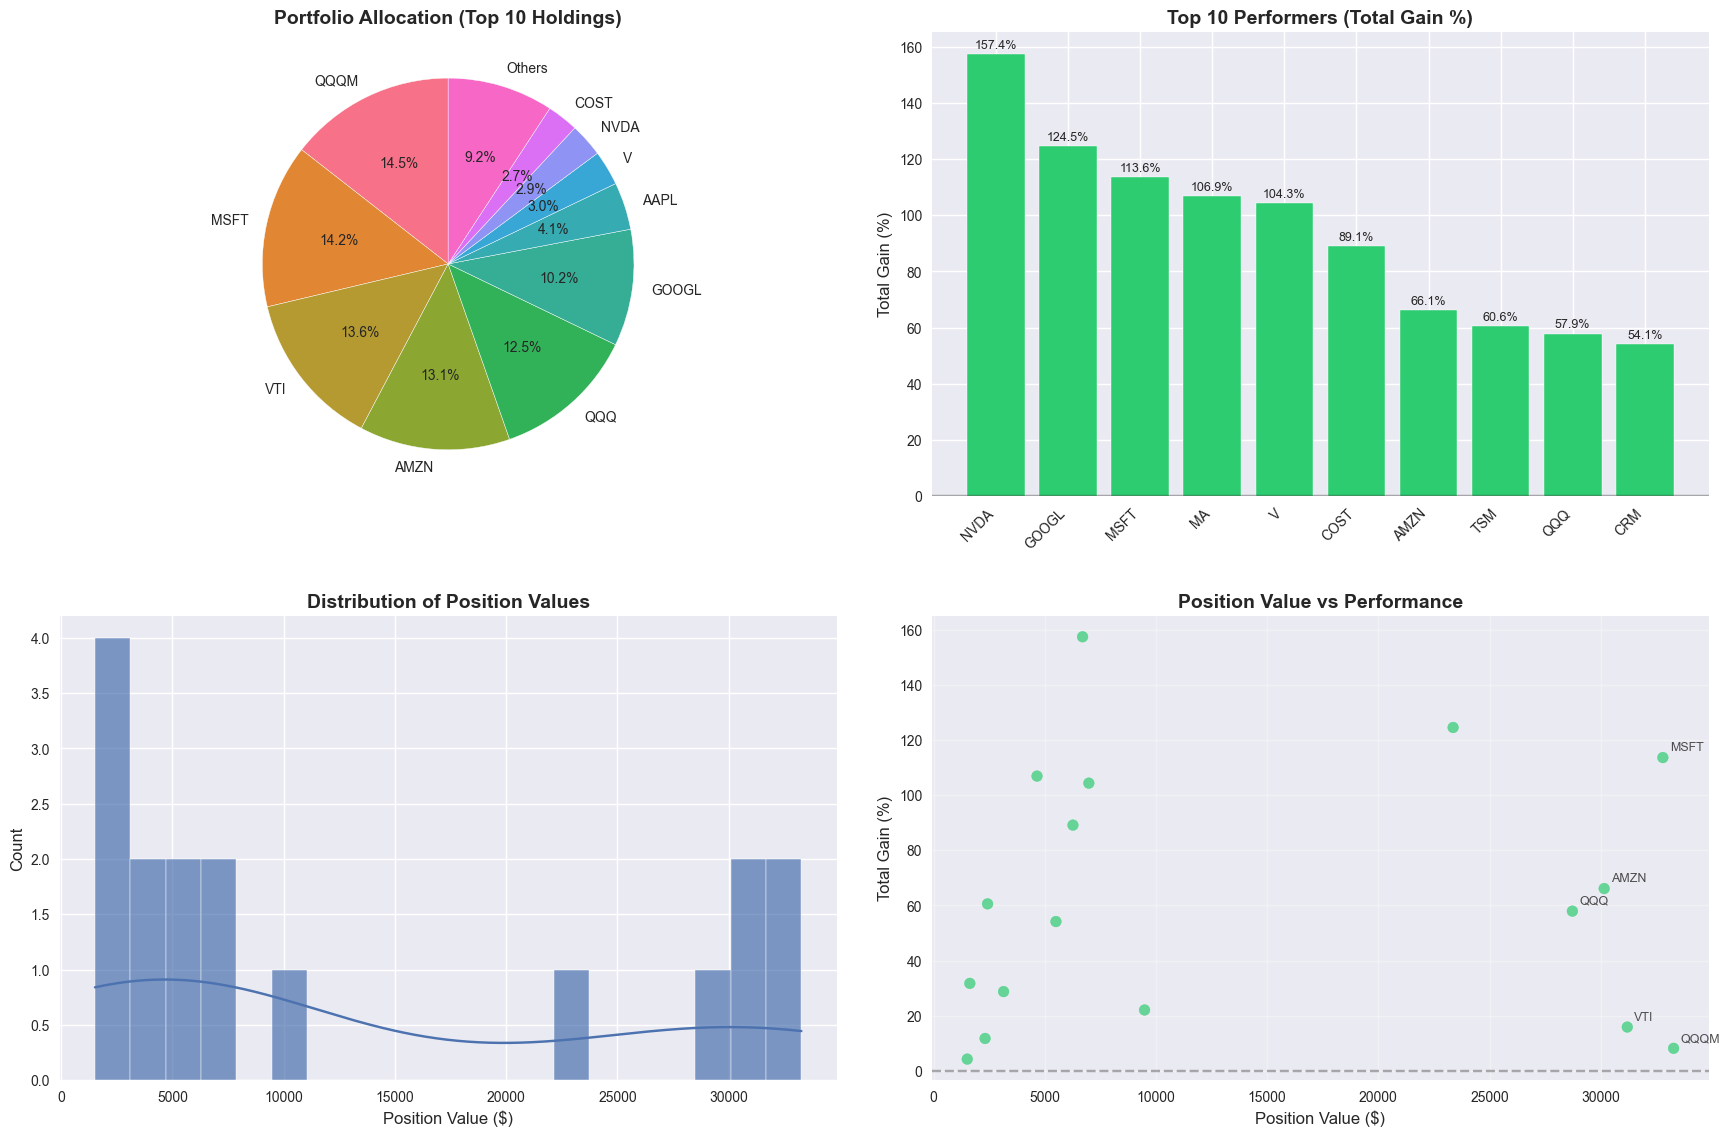


PORTFOLIO PERFORMANCE SUMMARY
📊 Total Portfolio Value: $230,094.35
💰 Total Unrealized Gain: $78,675.42
📈 Winning Positions: 17 (100.0%)
📉 Losing Positions: 0 (0.0%)
💵 Cash Position: $0.61 (0.0% of portfolio)


In [7]:
if positions_df is not None and not positions_df.empty:
    # Create subplots with seaborn styling
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
    
    # 1. Portfolio allocation pie chart
    top_10 = positions_df.nlargest(10, 'value')
    other_value = positions_df['value'].sum() - top_10['value'].sum()
    
    if other_value > 0:
        pie_data = list(top_10['value']) + [other_value]
        pie_labels = list(top_10['symbol']) + ['Others']
    else:
        pie_data = top_10['value']
        pie_labels = top_10['symbol']
    
    # Use seaborn color palette for pie chart
    colors = sns.color_palette("husl", len(pie_data))
    ax1.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', colors=colors, startangle=90)
    ax1.set_title('Portfolio Allocation (Top 10 Holdings)', fontsize=14, fontweight='bold')
    
    # 2. Performance bar chart
    gains_losses = positions_df.sort_values('total_gain_percent', ascending=False).head(10)
    
    # Create color map for gains/losses
    palette = ['#2ecc71' if x > 0 else '#e74c3c' for x in gains_losses['total_gain_percent']]
    
    bars = ax2.bar(range(len(gains_losses)), gains_losses['total_gain_percent'], color=palette)
    ax2.set_xticks(range(len(gains_losses)))
    ax2.set_xticklabels(gains_losses['symbol'], rotation=45, ha='right')
    ax2.set_ylabel('Total Gain (%)', fontsize=12)
    ax2.set_title('Top 10 Performers (Total Gain %)', fontsize=14, fontweight='bold')
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, gains_losses['total_gain_percent']):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + (1 if height > 0 else -3),
                f'{value:.1f}%', ha='center', va='bottom' if height > 0 else 'top', fontsize=9)
    
    # 3. Position value distribution
    sns.histplot(data=positions_df, x='value', bins=20, ax=ax3, kde=True, alpha=0.7)
    ax3.set_xlabel('Position Value ($)', fontsize=12)
    ax3.set_ylabel('Count', fontsize=12)
    ax3.set_title('Distribution of Position Values', fontsize=14, fontweight='bold')
    ax3.ticklabel_format(style='plain', axis='x')
    
    # 4. Gain/Loss scatter plot
    scatter_colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in positions_df['total_gain_percent']]
    ax4.scatter(positions_df['value'], positions_df['total_gain_percent'], 
               c=scatter_colors, alpha=0.7, s=60)
    
    # Add symbol labels for largest positions
    top_5_positions = positions_df.nlargest(5, 'value')
    for _, row in top_5_positions.iterrows():
        ax4.annotate(row['symbol'], 
                    (row['value'], row['total_gain_percent']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, alpha=0.8)
    
    ax4.set_xlabel('Position Value ($)', fontsize=12)
    ax4.set_ylabel('Total Gain (%)', fontsize=12)
    ax4.set_title('Position Value vs Performance', fontsize=14, fontweight='bold')
    ax4.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout(pad=3.0)
    plt.show()
    
    # Additional summary statistics
    print("\n" + "="*50)
    print("PORTFOLIO PERFORMANCE SUMMARY")
    print("="*50)
    
    total_value = positions_df['value'].sum() + cash_position
    total_gain = positions_df['total_gain_dollar'].sum()
    winners = len(positions_df[positions_df['total_gain_percent'] > 0])
    losers = len(positions_df[positions_df['total_gain_percent'] < 0])
    
    print(f"📊 Total Portfolio Value: ${total_value:,.2f}")
    print(f"💰 Total Unrealized Gain: ${total_gain:,.2f}")
    print(f"📈 Winning Positions: {winners} ({winners/len(positions_df)*100:.1f}%)")
    print(f"📉 Losing Positions: {losers} ({losers/len(positions_df)*100:.1f}%)")
    print(f"💵 Cash Position: ${cash_position:,.2f} ({cash_position/total_value*100:.1f}% of portfolio)")
    
else:
    print("No data available for visualization")